<a href="https://colab.research.google.com/github/ghirailghiro/GPU_Computing_Project/blob/10-add-sequential-algorithm/Gradient_First_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Cuda plugin

!pip install nvcc4jupyter
%load_ext nvcc4jupyter
!nvidia-smi

# plugin for cpp sintax highlighting

!wget -O cpp_plugin.py https://gist.github.com/akshaykhadse/7acc91dd41f52944c6150754e5530c4b/raw/cpp_plugin.py
%load_ext cpp_plugin

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpab9r0le8".
Sat Aug 31 15:51:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                 

In [2]:
!sudo apt update
!sudo apt install -y build-essential
!sudo apt install -y libopencv-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [962 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,561 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,425 kB]
Hit:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/GPU Computing/human detection dataset'

0  1


In [ ]:
!git clone --recursive https://github.com/YoungYoung619/pedestrian-detection-in-hazy-weather.git

In [52]:
%%writefile gradient_computation.cu
#include <opencv2/opencv.hpp>
#include <fstream>
#include <sstream>
#include <iostream>
#include <vector>
#include <filesystem>
#include <chrono>
#include <tuple>

namespace fs = std::filesystem;

// Global variables
int cellSize_g;
int blockSize_g;
int descriptorSizeDimension_g;
int numBins_g;
int dimofimage_g;

std::vector<std::tuple<std::string, std::string, double, double, double>> memoryUsageLog;

std::string current_filename_g;

void logMemoryUsage(const std::string& label) {
    size_t free_memory, total_memory;
    cudaMemGetInfo(&free_memory, &total_memory);
    size_t used_memory = total_memory - free_memory;

    double usedMemoryMB = used_memory / (1024.0 * 1024.0);
    double freeMemoryMB = free_memory / (1024.0 * 1024.0);
    double totalMemoryMB = total_memory / (1024.0 * 1024.0);

    memoryUsageLog.push_back(std::make_tuple(current_filename_g, label, usedMemoryMB, freeMemoryMB, totalMemoryMB));
}


void saveMemoryUsageLogToCSV(const std::string& filename) {
    std::ofstream file(filename);

    if (!file.is_open()) {
        std::cerr << "Error: Unable to open file " << filename << " for writing." << std::endl;
        return;
    }

    // Write CSV header
    file << "filename,Label,Used Memory (MB),Free Memory (MB),Total Memory (MB)\n";

    // Write each entry from the memoryUsageLog
    for (const auto& entry : memoryUsageLog) {
        file << std::get<0>(entry) << ","  // filename
             << std::get<1>(entry) << ","  // Label
             << std::get<2>(entry) << ","  // Used Memory (MB)
             << std::get<3>(entry) << ","  // Free Memory (MB)
             << std::get<4>(entry) << "\n";  // Total Memory (MB)
    }

    file.close();
}


void saveDescriptorAsCSVHeader(const std::vector<int>& descriptor, const std::string& filename, const std::string& label) {
    std::ofstream file(filename, std::ios::app);
    if (!file.is_open()) {
        std::cerr << "Error: Unable to open file " << filename << " for writing." << std::endl;
        return;
    }

    // Write the descriptor to the CSV file
    for (size_t i = 0; i < descriptor.size(); ++i) {
        file << "x" <<descriptor[i];
        if (i < descriptor.size() - 1) {
            file << ",";
        }
    }
    file << "," << "filename" << "," << "label" <<","<< "ExecTime" <<","<< "DimOfImage" << ","<<"ExecTimeMemLoading"<<"\n";
    file.close();
}


void saveDescriptorAsCSV(const std::vector<double>& descriptor, const std::string& filename,const std::string& path, int label,  double executionTime,  double executionTimeMemory) {
    std::ofstream file(filename, std::ios::app);
    if (!file.is_open()) {
        std::cerr << "Error: Unable to open file " << filename << " for writing." << std::endl;
        return;
    }

    // Write the descriptor to the CSV file
    for (size_t i = 0; i < descriptor.size(); ++i) {
        file << descriptor[i];
        if (i < descriptor.size() - 1) {
            file << ",";
        }
    }
    file << "," << path << "," << label << "," << executionTime <<","<< dimofimage_g <<","<< executionTimeMemory << "\n";
    file.close();
}

void computeGradients_seq(const cv::Mat& image, std::vector<float>& histograms, int cellSize, int numBins) {

    // Assuming image dimensions are reasonable for a grid of threads
    int width = image.cols;
    int height = image.rows;
    int numCellsX = width / cellSize;
    int numCellsY = height / cellSize;

    for (int idy = 0; idy < height; ++idy) {
        for (int idx = 0; idx < width; ++idx) {
            float G_x = 0, G_y = 0;
            if (idx > 0 && idx < width - 1) {
                G_x = static_cast<float>(image.at<uchar>(idy, idx + 1)) - static_cast<float>(image.at<uchar>(idy, idx - 1));
            }
            if (idy > 0 && idy < height - 1) {
                G_y = static_cast<float>(image.at<uchar>(idy + 1, idx)) - static_cast<float>(image.at<uchar>(idy - 1, idx));
            }

            float mag = std::sqrt(G_x * G_x + G_y * G_y);
            float orient = std::atan2(G_y, G_x);

            // Compute histogram bin for the current gradient
            int cellX = idx / cellSize;
            int cellY = idy / cellSize;
            int histIndex = cellY * numCellsX + cellX;
            //float binWidth = M_PI / numBins;
            //int bin = std::floor((orient + M_PI) / binWidth);
            //if (bin == numBins) bin = 0; // Wrap around
            //float binWidth = 2 * M_PI / numBins;
            //int bin = static_cast<int>(std::round((orient + M_PI) / binWidth)) % numBins;

            // Assuming numBins represents the number of bins for the [0, 180] degree range
            float binWidth = M_PI / numBins;  // Bin width for [0, π] range

            // Calculate the gradient orientation as an unsigned angle
            if (orient < 0) {
                orient += M_PI;  // Normalize to [0, π] range, example if we have -45°, we add 180° to get 135°
            }
            // Calculate the bin index
            int bin = static_cast<int>(std::round(orient / binWidth)) % numBins;

            int final_index = histIndex * numBins + bin;
            if (final_index >= histograms.size()) {
                std::cout << "Index out of bounds : " << final_index << std::endl;
            }else{
                histograms[final_index] += mag;
            }

        }
    }

    std::cout << "Ending computeGradients seq" << std::endl;
}

__global__ void computeGradients(unsigned char* image, float *d_histograms, int width, int height, int cellSize,float binWidth, int numBins, int histSize) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int idy = blockIdx.y * blockDim.y + threadIdx.y;
    int indexCurrent = idy * width + idx;

    if (idx >= width || idy >= height) return; // Boundary check

    float G_x = 0;
    // Compute gradients in x and y directions.
    //The conditional statements check if the current pixel is within the image boundaries.
    //If the pixel is not on the left or right edge of the image, the gradient in the x-direction is computed by subtracting the pixel value on the left from the pixel value on the right.
    if (idx > 0 && idx < width - 1) {
        G_x = (float)image[indexCurrent + 1] - (float)image[indexCurrent - 1];
    }

    float G_y = 0;
    if (idy > 0 && idy < height - 1) {
        G_y = (float)image[(idy + 1) * width + idx] - (float)image[(idy - 1) * width + idx]; // To Do: Capire formula??
    }

    float d_magnitude_var = sqrtf(G_x * G_x + G_y * G_y);
    float d_orientation_var = atan2f(G_y, G_x);

    // Compute histogram bin for the current gradient
    int cellX = idx / cellSize;
    int cellY = idy / cellSize;
    //The division (width / cellSize) calculates the ratio between the width of the grid and the size of each cell.
    //This ratio determines the number of cells that can fit horizontally in the grid.
    //By multiplying this ratio with cellY, we obtain the number of cells that can fit vertically up to the Y-coordinate cellY.
    //Finally, the expression cellY * (width / cellSize) + cellX adds the X-coordinate cellX to the previously calculated value.
    //This addition determines the absolute position of a cell within the grid, considering both its X and Y coordinates.
    int histIndex = cellY * (width / cellSize) + cellX;
    // TODO: Parametrizzare perchè da fare una volta sola
    //The following formula calculates the bin index for the current orientation value:
    /*1. `d_orientation[indexCurrent]`: This is a variable or an array element that holds the orientation value at the `indexCurrent` position.
        The orientation value is likely in radians.

    2. `M_PI`: This is a constant defined in the C++ math library that represents the value of pi (π).
        It is used to shift the orientation value by π radians.

    3. `(d_orientation[indexCurrent] + M_PI)`: This expression adds the orientation value to π, effectively shifting the range of values from [-π, π] to [0, 2π].

    4. `binWidth`: This is likely another variable or constant that represents the width of each bin. Bins are used to categorize or group values within a certain range.

    5. `(d_orientation[indexCurrent] + M_PI) / binWidth`: This expression divides the shifted orientation value by the bin width. The result is a floating-point number that represents the bin index.

    6. `floor((d_orientation[indexCurrent] + M_PI) / binWidth)`: The `floor()` function is used to round down the floating-point bin index to the nearest integer. This ensures that the bin index is an integer value.

    Overall, this code snippet calculates the bin index for a given orientation value by shifting the range of values, dividing by the bin width, and rounding down to the nearest integer.
    The bin index is commonly used in histogram calculations or other applications where values need to be grouped into bins or categories.
    */
    // Assuming numBins represents the number of bins for the [0, 180] degree range
    // Calculate the gradient orientation as an unsigned angle
    if (d_orientation_var < 0) {
        d_orientation_var += M_PI;  // Normalize to [0, π] range, example if we have -45°, we add 180° to get 135°
    }
    // Calculate the bin index
    int bin = __float2int_rn(d_orientation_var / binWidth) % numBins;

    int final_index = histIndex * numBins + bin;
    if (final_index >= histSize) {
        printf("Index out of bounds: %d\n", final_index);
    }else{
      atomicAdd(&d_histograms[final_index], d_magnitude_var);
    }
}

std::vector<double> computeDescriptorsCUDA(const cv::Mat& image, double& executionTime, double& LoadingInMemoryTime) {
    int numCellsX = image.cols / cellSize_g;
    int numCellsY = image.rows / cellSize_g;
    cudaDeviceSynchronize();
    logMemoryUsage("Before memory allocation");
    auto startMemory = std::chrono::high_resolution_clock::now();
    unsigned char* d_image;
    size_t imageSize = image.total() * image.elemSize();
    cudaError_t status = cudaMalloc(&d_image, imageSize);
    // Allocate memory for orientation
    if (status != cudaSuccess) {
        // Handle error (e.g., printing an error message and exiting)
        fprintf(stderr, "cudaMalloc failed: %s\n", cudaGetErrorString(status));
        exit(EXIT_FAILURE);
    }
    // Initialize d_orientation to zero
    status = cudaMemcpy(d_image, image.data, imageSize, cudaMemcpyHostToDevice);
    if (status != cudaSuccess) {
        // Handle error
        fprintf(stderr, "cudaMemset failed: %s\n", cudaGetErrorString(status));
        exit(EXIT_FAILURE);
    }
    // hist size is the number of cells in the x and y direction times 9 bins per cell
    size_t histSize = numCellsX * numCellsY * numBins_g * sizeof(float); //TODO: Parametrizzare il num di bin
    float* d_histograms; //device histograms
    // Allocate memory for histograms
    status = cudaMalloc((void **)&d_histograms, histSize);
    if (status != cudaSuccess) {
        // Handle error
        fprintf(stderr, "cudaMalloc failed: %s\n", cudaGetErrorString(status));
        exit(EXIT_FAILURE);
    }
    // Initialize histograms to zero
    status = cudaMemset(d_histograms, 0, histSize);
    if (status != cudaSuccess) {
        // Handle error
        fprintf(stderr, "cudaMemset failed: %s\n", cudaGetErrorString(status));
        exit(EXIT_FAILURE);
    }
    auto endMemory = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsedMemory = endMemory - startMemory;
    LoadingInMemoryTime = elapsedMemory.count();
    cudaDeviceSynchronize();
    logMemoryUsage("After allocating memory");

    std::cout << "Loading Memory Time Step"<< LoadingInMemoryTime << std::endl;

    // Assuming image dimensions are reasonable for a blocksize 16x16
    //By dividing the image dimensions by the block size and rounding up to the nearest integer, the grid size is determined.
    //The -1 in the calculation is used to handle cases where the image dimensions are not evenly divisible by the block size.
    //This ensures that any remaining pixels are included in the grid.
    dim3 blockSize(16, 16);
    dim3 gridSize((image.cols + blockSize.x - 1) / blockSize.x,
                  (image.rows + blockSize.y - 1) / blockSize.y);
    //TODO: Print gridsize.x and gridsize.y;


    // Bin width for [0, π] range
    float binWidth = M_PI / numBins_g;
    int histSize_vec = numCellsX * numCellsY * numBins_g;

    auto start = std::chrono::high_resolution_clock::now();
    // Launch the kernel
    computeGradients<<<gridSize, blockSize>>>(d_image, d_histograms, image.cols, image.rows, cellSize_g, binWidth, numBins_g, histSize_vec);
    cudaDeviceSynchronize();
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    executionTime = elapsed.count();

    // Transfer histogram data from device to host
    auto startMemoryFromDevice = std::chrono::high_resolution_clock::now();
    float* h_histograms = new float[numCellsX * numCellsY * numBins_g];
    status = cudaMemcpy(h_histograms, d_histograms, histSize, cudaMemcpyDeviceToHost);
    if (status != cudaSuccess) {
        // Handle error
        fprintf(stderr, "cudaMemcpy failed: %s\n", cudaGetErrorString(status));
        exit(EXIT_FAILURE);
    }
    auto endMemoryFromDevice = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsedMemoryFromDevice = endMemoryFromDevice - startMemoryFromDevice;
    LoadingInMemoryTime += elapsedMemoryFromDevice.count();

    std::cout << "Loading Memory Time Final"<< LoadingInMemoryTime << std::endl;

    // Normalization of histograms using the sum of squares with L2-norm per cell - TODO : modify and do it per block

    // Block Formation and Descriptor Computation with Block-Level Normalization
    std::vector<double> descriptor;
    for (int i = 0; i <= numCellsY - blockSize_g; ++i) {
        for (int j = 0; j <= numCellsX - blockSize_g; ++j) {
            // Step 1: Calculate the L2-norm for the block
            double blockNorm = 0;
            for (int y = i; y < i + blockSize_g; ++y) {
                for (int x = j; x < j + blockSize_g; ++x) {
                    for (int k = 0; k < numBins_g; ++k) {
                        float histValue = h_histograms[(y * numCellsX + x) * numBins_g + k];
                        blockNorm += histValue * histValue;
                    }
                }
            }
            blockNorm = sqrtf((blockNorm*blockNorm) + 1e-6 * 1e-6); // Small constant to avoid division by zero

            // Step 2: Normalize the histograms within the block
            for (int y = i; y < i + blockSize_g; ++y) {
                for (int x = j; x < j + blockSize_g; ++x) {
                    for (int k = 0; k < numBins_g; ++k) {
                        double normalizedValue = h_histograms[(y * numCellsX + x) * numBins_g + k] / blockNorm;
                        descriptor.push_back(normalizedValue);
                    }
                }
            }
        }
    }

    cudaFree(d_image);
    delete[] h_histograms;
    cudaFree(d_histograms);
    cudaDeviceSynchronize();
    logMemoryUsage("After freeing all memory");


    return descriptor;
}

std::vector<double> computeDescriptorsSeq(const cv::Mat& image, double& executionTime) {

    int numCellsX = image.cols / cellSize_g;
    int numCellsY = image.rows / cellSize_g;

    // Allocate memory for histograms
    std::vector<float> histograms(numCellsX * numCellsY * numBins_g, 0.0f);
    auto start = std::chrono::high_resolution_clock::now();
    computeGradients_seq(image, histograms, cellSize_g, numBins_g);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    executionTime = elapsed.count();

    std::cout << "Before computing descriptor seq" << std::endl;

    // Block Formation and Descriptor Computation with Block-Level Normalization
    std::vector<double> descriptor;
    for (int i = 0; i <= numCellsY - blockSize_g; ++i) {
        for (int j = 0; j <= numCellsX - blockSize_g; ++j) {
            // Step 1: Calculate the L2-norm for the block
            double blockNorm = 0;
            for (int y = i; y < i + blockSize_g; ++y) {
                for (int x = j; x < j + blockSize_g; ++x) {
                    for (int k = 0; k < numBins_g; ++k) {
                        float histValue = histograms[(y * numCellsX + x) * numBins_g + k];
                        blockNorm += histValue * histValue;
                    }
                }
            }

            blockNorm = sqrtf((blockNorm*blockNorm) + 1e-6 * 1e-6); // Small constant to avoid division by zero
            // Step 2: Normalize the histograms within the block
            for (int y = i; y < i + blockSize_g; ++y) {
                for (int x = j; x < j + blockSize_g; ++x) {
                    for (int k = 0; k < numBins_g; ++k) {
                        double normalizedValue = histograms[(y * numCellsX + x) * numBins_g + k] / blockNorm;
                        descriptor.push_back(normalizedValue);
                    }
                }
            }
        }
    }

    std::cout << "Ending computing descriptor seq" << std::endl;


    return descriptor;
}

std::vector<double> computeDescriptors(const std::string& image_path, double& executionTime, double& LoadingInMemoryTime, bool cudaAccelerated = true) {
    // Load an image using OpenCV
    cv::Mat imageBeforeResize = cv::imread(image_path, cv::IMREAD_GRAYSCALE);
    cv::Mat image;
    cv::resize(imageBeforeResize, image, cv::Size(dimofimage_g, dimofimage_g)); // Resize to standard size -- TODO: Refactor
    if(image.empty()) {
        std::cerr << "Failed to load image." << std::endl;
        return std::vector<double>();
    }
    std::vector<double> descriptor;
    if(cudaAccelerated) {
        descriptor = computeDescriptorsCUDA(image, executionTime, LoadingInMemoryTime);
    } else {
        descriptor = computeDescriptorsSeq(image, executionTime);
    }
    std::cout << "End COMPUTE DESCRIPTOR ----------" << std::endl;

    return descriptor;
}

int main(int argc, char** argv) {
     if (argc != 6) {
        std::cerr << "Usage: " << argv[0] << " <cellSize> <blockSize> <numBins> <outputFile> <dimofimage>" << std::endl;
        return 1;
    }

    cellSize_g = std::stoi(argv[1]);
    blockSize_g = std::stoi(argv[2]);
    numBins_g = std::stoi(argv[3]);
    std::string outputFile = argv[4];
    dimofimage_g = std::stoi(argv[5]);//224

    // Calcute numbers of cells in x and y direction
    int numCellsX = dimofimage_g / cellSize_g;
    int numCellsY = dimofimage_g / cellSize_g;
    /*This is how we calculate the descriptorSizeDimension:

    1. `(numCellsY - blockSize + 1)` calculates the number of blocks in the Y direction.
        Here, `numCellsY` represents the total number of cells in the Y direction, and `blockSize` represents the size of each block.
        By subtracting `blockSize - 1` from `numCellsY`, we account for the overlapping blocks.

    2. `(numCellsX - blockSize + 1)` calculates the number of blocks in the X direction.
        Similar to the previous step, `numCellsX` represents the total number of cells in the X direction, and `blockSize` represents the size of each block.
        Again, we subtract `blockSize - 1` to account for the overlapping blocks.

    3. `blockSize * blockSize` calculates the number of cells within each block.
        Since the blocks are square, we multiply the `blockSize` by itself to get the total number of cells in a block.

    4. `numBins` represents the number of bins used for the descriptor. Each cell in the histogram contains `numBins` values.
        By multiplying all these values together, we get the total size of the descriptor.
        The descriptor size is the product of the number of blocks in the X and Y directions, the number of cells within each block, and the number of bins.
    */
    descriptorSizeDimension_g = (numCellsY - blockSize_g + 1) * (numCellsX - blockSize_g + 1) * blockSize_g * blockSize_g * numBins_g;

    std::string folder_path = "/content/drive/My Drive/GPU Computing/human detection dataset/1"; // Change this to your folder path
    std::vector<int> header;
    for (int i=1; i <= descriptorSizeDimension_g; ++i){
      header.push_back(i);
    }
    std::cout << "Descriptor size : " << descriptorSizeDimension_g << std::endl;
    std::string seq_file = outputFile+"_seq.csv";
    std::string cuda_file = outputFile+"_cuda.csv";
    std::cout << seq_file << std::endl;
    std::cout << cuda_file << std::endl;
    saveDescriptorAsCSVHeader(header, seq_file, "label");
    saveDescriptorAsCSVHeader(header, cuda_file, "label");
    header.clear();
    //Iterate on images where a human is present
    for (const auto& entry : fs::directory_iterator(folder_path)) {
        std::string file_path = entry.path().string();
        std::cout << "Processing image: " << file_path << std::endl;

        double executionTimeCuda = 0.0;
        double executionTimeSeq = 0.0;
        double loadingTimeInMemoryCuda = 0.0;
        double loadingTimeInMemorySeq = 0.0;
        std::vector<double> descriptor = computeDescriptors(file_path, executionTimeCuda, loadingTimeInMemoryCuda);
        std::vector<double> descriptor_seq = computeDescriptors(file_path, executionTimeSeq, loadingTimeInMemorySeq, false);
        //std::vector<double> descriptor_seq;
        current_filename_g = file_path;
        if (descriptor_seq.empty()) {
            std::cout << "Vector is empty" << std::endl;
        } else {
            int label = 1;
            std::cout << descriptor_seq.size() << std::endl;
            std::cout << descriptor[0] << std::endl;
            std::cout << descriptor_seq[0] << std::endl;
            saveDescriptorAsCSV(descriptor, cuda_file, file_path, label, executionTimeCuda, loadingTimeInMemoryCuda);
            saveDescriptorAsCSV(descriptor_seq, seq_file, file_path, label, executionTimeSeq, loadingTimeInMemorySeq);
        }
        descriptor.clear(); // Clear the vector
        descriptor_seq.clear();
        //break;
    }

      //Iterate on images where a human is NOT present
      folder_path = "/content/drive/My Drive/GPU Computing/human detection dataset/0";
      for (const auto& entry : fs::directory_iterator(folder_path)) {
        std::string file_path = entry.path().string();
        std::cout << "Processing image: " << file_path << std::endl;

        double executionTimeCuda = 0.0;
        double executionTimeSeq = 0.0;
        double loadingTimeInMemoryCuda = 0.0;
        double loadingTimeInMemorySeq = 0.0;
        std::vector<double> descriptor = computeDescriptors(file_path, executionTimeCuda, loadingTimeInMemoryCuda);
        std::vector<double> descriptor_seq = computeDescriptors(file_path, executionTimeSeq, loadingTimeInMemorySeq, false);        //std::vector<double> descriptor_seq;
        current_filename_g = file_path;
        if (descriptor_seq.empty()) {
            std::cout << "Vector is empty" << std::endl;
        } else {
            int label = 0;
            std::cout << descriptor_seq.size() << std::endl;
            saveDescriptorAsCSV(descriptor, cuda_file, file_path, label, executionTimeCuda, loadingTimeInMemoryCuda);
            saveDescriptorAsCSV(descriptor_seq, seq_file, file_path, label, executionTimeSeq, loadingTimeInMemorySeq);
        }
        descriptor.clear(); // Clear the vector
        descriptor_seq.clear();
        //break;
    }

    saveMemoryUsageLogToCSV(outputFile+"_memory_usage_cuda_log.csv");

    return 0;
}

Overwriting gradient_computation.cu


In [57]:
%%bash
# Compile the CUDA code with OpenCV support
echo "Compiling CUDA code..."
nvcc gradient_computation.cu -o gradient_computation `pkg-config --cflags --libs opencv4`
echo "Compilation finished."

# Define the path to the executable
EXECUTABLE="./gradient_computation"

# Define the output directory for the CSV files
OUTPUT_DIR="./output"

# Create the output directory if it doesn't exist
echo "Creating output directory..."
mkdir -p $OUTPUT_DIR
echo "Output directory created: $OUTPUT_DIR"

# Get the current date and time
CURRENT_TIME=$(date +"%Y%m%d_%H%M%S")
echo "Current timestamp: $CURRENT_TIME"

# Experiment parameters
CELL_SIZES=(64 32 16 8)      # Cell sizes to experiment with
BLOCK_SIZES=(2)
NUM_BINS=(9)              # Number of bins
DIMENSIONS=(64 128 256) # Added dimension list

OUTPUT_FILE_BASENAME="descriptor"

# Run experiments
for dim_img in "${DIMENSIONS[@]}"; do
    for cell_size in "${CELL_SIZES[@]}"; do
        for block_size in "${BLOCK_SIZES[@]}"; do
            for num_bins in "${NUM_BINS[@]}"; do
                # Construct the output file name
                OUTPUT_FILE="${OUTPUT_DIR}/${OUTPUT_FILE_BASENAME}_dim${dim_img}_cell${cell_size}_block${block_size}_bins${num_bins}_${CURRENT_TIME}"

                # Run the experiment
                echo "Running experiment with image dimension: $dim_img, cell size: $cell_size, block size: $block_size, num bins: $num_bins"
                $EXECUTABLE $cell_size $block_size $num_bins $OUTPUT_FILE $dim_img

                echo "Output written to: $OUTPUT_FILE"
            done
        done
    done
done

echo "All experiments completed."

# Define the target directory
TARGET_DIR="/content/drive/My Drive/GPU Computing/output"

# Create the target directory if it doesn't exist
echo "Creating target directory on Google Drive..."
mkdir -p "$TARGET_DIR"
echo "Target directory created: $TARGET_DIR"

# Copy all files from the output directory to the target directory
echo "Copying files to Google Drive..."
cp $OUTPUT_DIR/* "$TARGET_DIR"

echo "All files copied to $TARGET_DIR."


Compiling CUDA code...
Compilation finished.
Creating output directory...
Output directory created: ./output
Current timestamp: 20240831_161939
Running experiment with image dimension: 64, cell size: 64, block size: 2, num bins: 9
Descriptor size : 0
./output/descriptor_dim64_cell64_block2_bins9_20240831_161939_seq.csv
./output/descriptor_dim64_cell64_block2_bins9_20240831_161939_cuda.csv
Processing image: /content/drive/My Drive/GPU Computing/human detection dataset/1/140.png
Loading Memory Time Step0.000155451
Loading Memory Time Final0.000174285
End COMPUTE DESCRIPTOR ----------
Ending computeGradients seq
Before computing descriptor seq
Ending computing descriptor seq
End COMPUTE DESCRIPTOR ----------
Vector is empty
Processing image: /content/drive/My Drive/GPU Computing/human detection dataset/1/157.png
Loading Memory Time Step0.000172358
Loading Memory Time Final0.000192493
End COMPUTE DESCRIPTOR ----------
Ending computeGradients seq
Before computing descriptor seq
Ending compu

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [47]:
%%bash
OUTPUT_DIR="./output"
# Define the target directory
TARGET_DIR="/content/drive/My Drive/GPU Computing/output"

# Copy all files from the output directory to the target directory
cp $OUTPUT_DIR/* "$TARGET_DIR"

In [56]:
rm -r output

In [53]:
!nvcc gradient_computation.cu -o gradient_computation `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [38]:
!./gradient_computation 64 2 9 test 256

Descriptor size : 324
test_seq.csv
test_cuda.csv
Processing image: /content/drive/My Drive/GPU Computing/human detection dataset/1/140.png
Loading Memory Time Step0.000208261
Loading Memory Time Final0.000230872
End COMPUTE DESCRIPTOR ----------
Ending computeGradients seq
Before computing descriptor seq
Ending computing descriptor seq
End COMPUTE DESCRIPTOR ----------
324
2.43313e-06
2.43357e-06
Processing image: /content/drive/My Drive/GPU Computing/human detection dataset/0/127.png
Loading Memory Time Step0.000241133
Loading Memory Time Final0.000260563
End COMPUTE DESCRIPTOR ----------
Ending computeGradients seq
Before computing descriptor seq
Ending computing descriptor seq
End COMPUTE DESCRIPTOR ----------
324


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

path = '/content/drive/My Drive/GPU Computing/output'

all_files = os.listdir(path)
col_list = ["filename",	"label"	,"ExecTime"	,"DimOfImage"	,"ExecTimeMemLoading","File","Type","descriptor_dim"]
df_list = []
for fil in all_files:
  df = pd.read_csv(path+'/'+fil)
  df["File"] = fil
  if "cuda" in fil:
    df["Type"] = "CUDA"
  else:
    df["Type"] = "SEQ"
  descriptor_dimension = len(df.columns) - 7  # Subtracting 1 for 'execution_time' column

  # Add the descriptor dimension as a new column
  df["descriptor_dim"] = descriptor_dimension
  check_col = all([i in df.columns for i in col_list])
  if check_col:
    df = df[col_list]
  df_list.append(df)

# # Concatenate all dataframes into one
combined_df = pd.concat(df_list, ignore_index=True)

# # Group by descriptor dimension and calculate the mean execution time
mean_execution_time = combined_df[~combined_df['File'].str.contains("memory_usage")].groupby(['descriptor_dim', 'Type','File'])[['ExecTime', 'ExecTimeMemLoading']].mean().reset_index()

print(mean_execution_time)


    descriptor_dim  Type                                               File  \
0               36  CUDA  descriptor_dim128_cell64_block2_bins9_20240831...   
1               36  CUDA  descriptor_dim64_cell32_block2_bins9_20240831_...   
2               36   SEQ  descriptor_dim128_cell64_block2_bins9_20240831...   
3               36   SEQ  descriptor_dim64_cell32_block2_bins9_20240831_...   
4              324  CUDA  descriptor_dim128_cell32_block2_bins9_20240831...   
5              324  CUDA  descriptor_dim256_cell64_block2_bins9_20240831...   
6              324  CUDA  descriptor_dim64_cell16_block2_bins9_20240831_...   
7              324   SEQ  descriptor_dim128_cell32_block2_bins9_20240831...   
8              324   SEQ  descriptor_dim256_cell64_block2_bins9_20240831...   
9              324   SEQ  descriptor_dim64_cell16_block2_bins9_20240831_...   
10            1764  CUDA  descriptor_dim128_cell16_block2_bins9_20240831...   
11            1764  CUDA  descriptor_dim256_cell32_b

<ipython-input-2-30cc813dd6a1>:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(df_list, ignore_index=True)


In [3]:
# # Group by descriptor dimension and calculate the mean execution time
mean_execution_time = combined_df[~(combined_df['File'].str.contains("memory_usage"))].groupby(['descriptor_dim', 'Type','DimOfImage'])[['ExecTime', 'ExecTimeMemLoading']].mean().reset_index()

print(mean_execution_time)

    descriptor_dim  Type  DimOfImage  ExecTime  ExecTimeMemLoading
0               36  CUDA        64.0  0.000029            0.000170
1               36  CUDA       128.0  0.000044            0.000182
2               36   SEQ        64.0  0.000435            0.000000
3               36   SEQ       128.0  0.001611            0.000000
4              324  CUDA        64.0  0.000028            0.000173
5              324  CUDA       128.0  0.000035            0.000184
6              324  CUDA       256.0  0.000072            0.000195
7              324   SEQ        64.0  0.000436            0.000000
8              324   SEQ       128.0  0.001630            0.000000
9              324   SEQ       256.0  0.006708            0.000000
10            1764  CUDA        64.0  0.000030            0.000188
11            1764  CUDA       128.0  0.000031            0.000182
12            1764  CUDA       256.0  0.000051            0.000201
13            1764   SEQ        64.0  0.000437            0.00

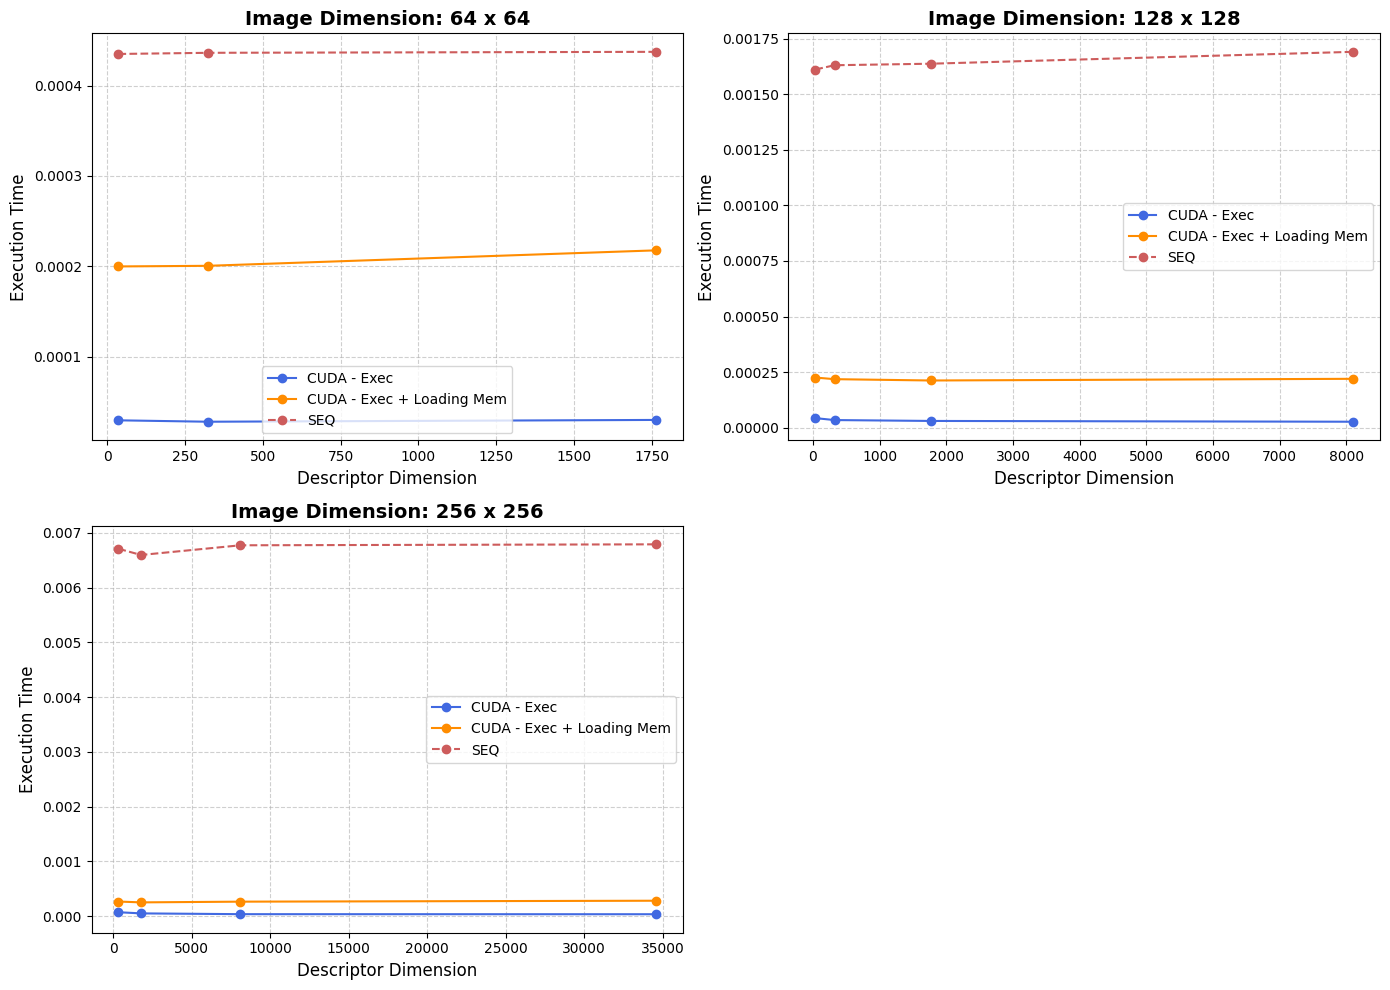

In [8]:
# Create a 2x2 grid of plots, one for each unique image dimension
cuda_data = mean_execution_time[mean_execution_time['Type'] == 'CUDA']
seq_data = mean_execution_time[mean_execution_time['Type'] == 'SEQ']

unique_dims = mean_execution_time['DimOfImage'].astype(int).unique()
num_dims = len(unique_dims)

# Create a 2x2 grid of plots, excluding the 4th image dimension
dims_to_plot = unique_dims[:3]  # Exclude the 4th dimension

# Set up the 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Plot each dimension in a separate subplot
for i, dim in enumerate(dims_to_plot):
    ax = axs[i]

    # Plot CUDA execution times
    ax.plot(cuda_data[cuda_data['DimOfImage'] == dim]['descriptor_dim'],
            cuda_data[cuda_data['DimOfImage'] == dim]['ExecTime'],
            marker='o', linestyle='-', color='royalblue', label='CUDA - Exec')

    # Plot CUDA execution times + loading time
    ax.plot(cuda_data[cuda_data['DimOfImage'] == dim]['descriptor_dim'],
            cuda_data[cuda_data['DimOfImage'] == dim]['ExecTime'] +
            cuda_data[cuda_data['DimOfImage'] == dim]['ExecTimeMemLoading'],
            marker='o', linestyle='-', color='darkorange', label='CUDA - Exec + Loading Mem')

    # Plot SEQ execution times
    ax.plot(seq_data[seq_data['DimOfImage'] == dim]['descriptor_dim'],
            seq_data[seq_data['DimOfImage'] == dim]['ExecTime'],
            marker='o', linestyle='--', color='indianred', label='SEQ')

    ax.set_title(f'Image Dimension: {dim} x {dim}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Descriptor Dimension', fontsize=12)
    ax.set_ylabel('Execution Time', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide the last subplot (4th position)
axs[3].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

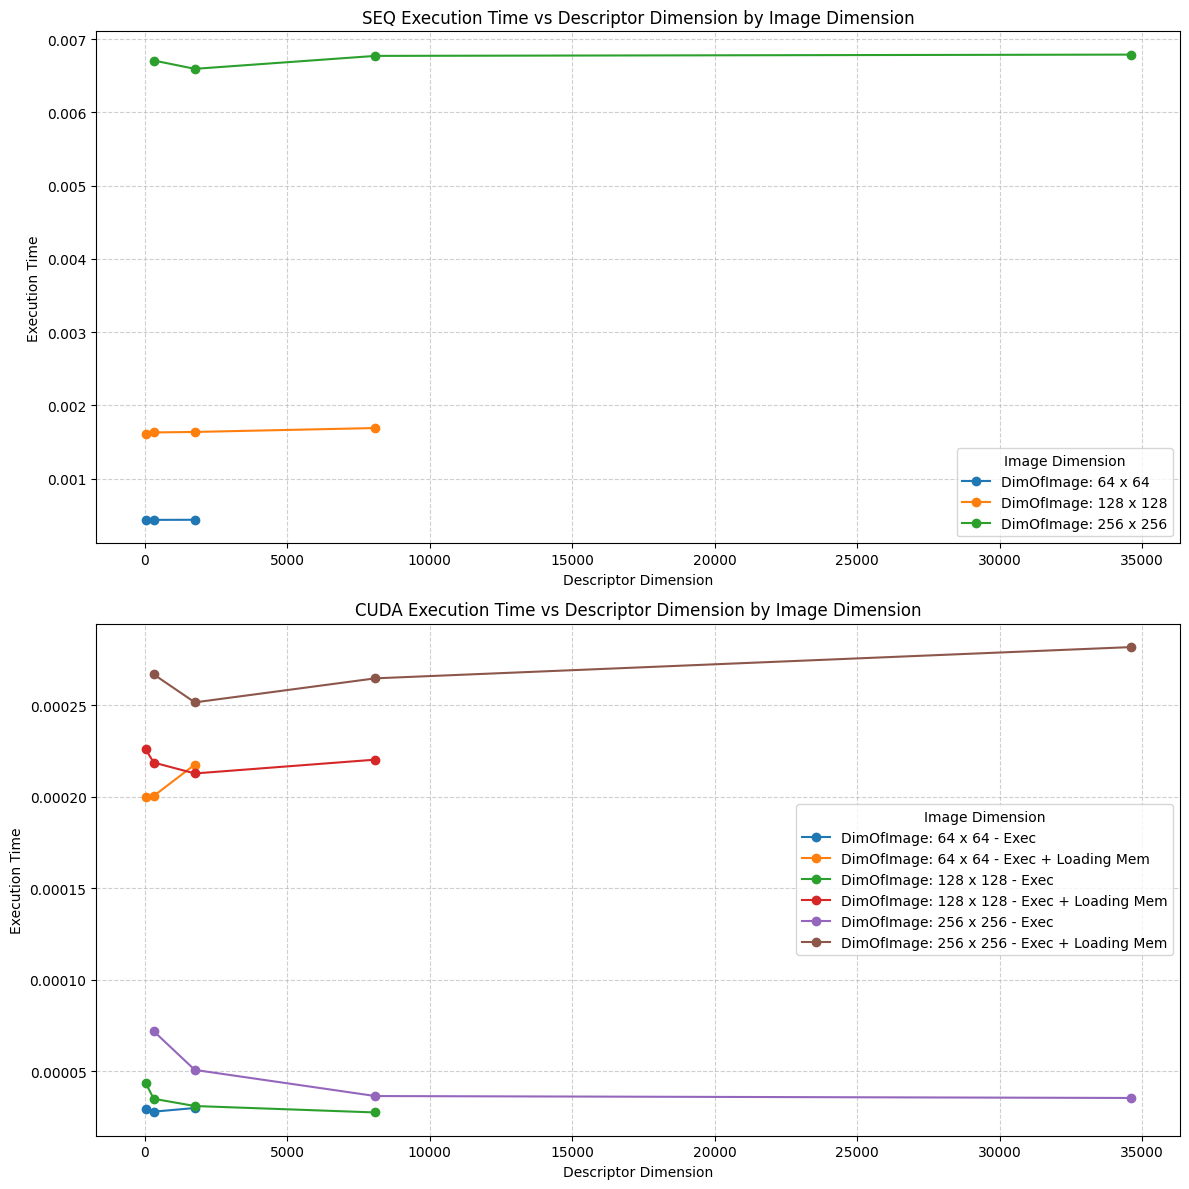

In [9]:
# Set up the 2x1 grid
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot for SEQ experiments using 'DimOfImage' as color
for dim in seq_data['DimOfImage'].astype(int).unique():
    axs[0].plot(seq_data[seq_data['DimOfImage'] == dim]['descriptor_dim'],
                seq_data[seq_data['DimOfImage'] == dim]['ExecTime'],
                marker='o', linestyle='-', label=f'DimOfImage: {dim} x {dim}')

axs[0].set_xlabel('Descriptor Dimension')
axs[0].set_ylabel('Execution Time')
axs[0].set_title('SEQ Execution Time vs Descriptor Dimension by Image Dimension')
axs[0].legend(title='Image Dimension')
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plot for CUDA experiments using 'DimOfImage' as color
for dim in cuda_data['DimOfImage'].astype(int).unique():
    axs[1].plot(cuda_data[cuda_data['DimOfImage'] == dim]['descriptor_dim'],
                cuda_data[cuda_data['DimOfImage'] == dim]['ExecTime'],
                marker='o', linestyle='-', label=f'DimOfImage: {dim} x {dim} - Exec')

    axs[1].plot(cuda_data[cuda_data['DimOfImage'] == dim]['descriptor_dim'],
            cuda_data[cuda_data['DimOfImage'] == dim]['ExecTime'] +
            cuda_data[cuda_data['DimOfImage'] == dim]['ExecTimeMemLoading'],
            marker='o', linestyle='-', label=f'DimOfImage: {dim} x {dim} - Exec + Loading Mem')

axs[1].set_xlabel('Descriptor Dimension')
axs[1].set_ylabel('Execution Time')
axs[1].set_title('CUDA Execution Time vs Descriptor Dimension by Image Dimension')
axs[1].legend(title='Image Dimension')
axs[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [47]:
filtered_memory_logs = combined_df[(combined_df['File'].str.contains("memory_usage")) & (combined_df["Type"] == 'CUDA')]

filtered_memory_logs['DimOfImage'] = filtered_memory_logs["File"].apply(lambda row: int(row.split('_')[1].replace('dim', '')))

mean_gpu_memory_usage = filtered_memory_logs.groupby(['Label'])[['Used Memory (MB)','Free Memory (MB)', 'Total Memory (MB)']].mean().reset_index()

print(mean_gpu_memory_usage)

                      Label  Used Memory (MB)  Free Memory (MB)  \
0   After allocating memory        114.989142      14987.110858   
1  After freeing all memory        113.000000      14989.100000   
2  Before memory allocation        112.989142      14989.110858   

   Total Memory (MB)  
0            15102.1  
1            15102.1  
2            15102.1  


<ipython-input-47-65d73afe2fb0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_memory_logs['DimOfImage'] = filtered_memory_logs["File"].apply(lambda row: int(row.split('_')[1].replace('dim', '')))


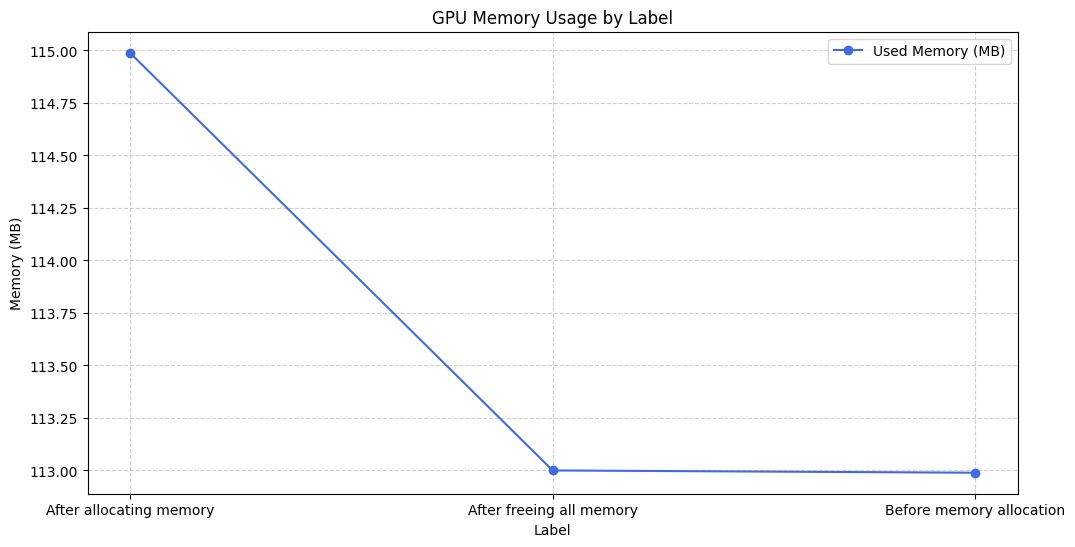

In [49]:
import pandas as pd

# Plotting the memory usage
plt.figure(figsize=(12, 6))

# Plot used memory
plt.plot(mean_gpu_memory_usage['Label'], mean_gpu_memory_usage['Used Memory (MB)'], marker='o', linestyle='-', color='royalblue', label='Used Memory (MB)')

plt.xlabel('Label')
plt.ylabel('Memory (MB)')
plt.title('GPU Memory Usage by Label')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


<ipython-input-14-ebd758f8ccad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuda_df['TotalExecTime'] = cuda_df["ExecTime"] + cuda_df["ExecTimeMemLoading"]


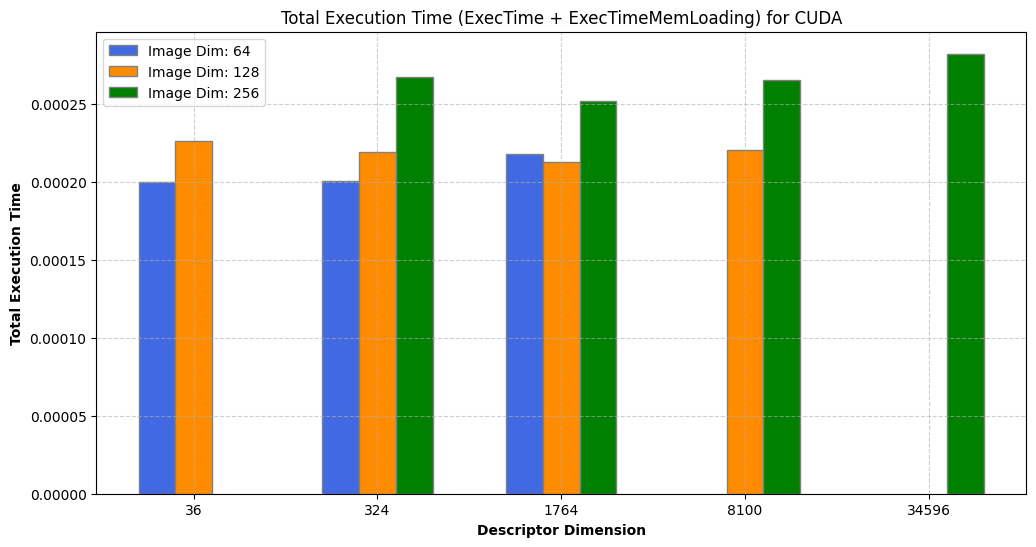

In [14]:
# Filter the data for CUDA
import numpy as np
cuda_df = mean_execution_time[mean_execution_time['Type'] == 'CUDA']
cuda_df['TotalExecTime'] = cuda_df["ExecTime"] + cuda_df["ExecTimeMemLoading"]
# Prepare data for the bar plot
descriptor_dims = cuda_df['descriptor_dim'].unique()
image_dims = [64.0, 128.0, 256.0]

# Create a dataframe for plotting
plot_data = pd.DataFrame(index=descriptor_dims)

for dim in image_dims:
    subset = cuda_df[cuda_df['DimOfImage'] == dim].set_index('descriptor_dim')
    plot_data[f'Image Dim: {dim}'] = subset['TotalExecTime']

# Set the width of the bars
bar_width = 0.2
r = np.arange(len(plot_data))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(r, plot_data['Image Dim: 64.0'], color='royalblue', width=bar_width, edgecolor='grey', label='Image Dim: 64')
plt.bar(r + bar_width, plot_data['Image Dim: 128.0'], color='darkorange', width=bar_width, edgecolor='grey', label='Image Dim: 128')
plt.bar(r + 2 * bar_width, plot_data['Image Dim: 256.0'], color='green', width=bar_width, edgecolor='grey', label='Image Dim: 256')

# Add labels and title
plt.xlabel('Descriptor Dimension', fontweight='bold')
plt.ylabel('Total Execution Time', fontweight='bold')
plt.xticks(r + bar_width, plot_data.index)
plt.title('Total Execution Time (ExecTime + ExecTimeMemLoading) for CUDA')

# Add legend and show plot
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import pandas as pd
import os
import matplotlib.pyplot as plt

path = '/content/drive/My Drive/GPU Computing/output'

all_files = os.listdir(path)
col_list = ["filename",	"label"	,"ExecTime"	,"DimOfImage"	,"ExecTimeMemLoading","File","Type","descriptor_dim"]
df_list_acc = []
for fil in all_files:
  df = pd.read_csv(path+'/'+fil)
  df["File"] = fil
  if "cuda" in fil:
    df["Type"] = "CUDA"
  else:
    df["Type"] = "SEQ"
  descriptor_dimension = len(df.columns) - 7  # Subtracting 1 for 'execution_time' column

  # Add the descriptor dimension as a new column
  df["descriptor_dim"] = descriptor_dimension
  check_col = all([i in df.columns for i in col_list])
  if check_col:
    df_list_acc.append(df)
  else:
    continue



In [44]:
col_list = ["filename",	"label"	,"ExecTime"	,"DimOfImage"	,"ExecTimeMemLoading","File","Type","descriptor_dim"]
from sklearn.svm import SVC
import re
from sklearn.metrics import accuracy_score, recall_score

result_list = []
for df in df_list_acc:
  if df.shape[0] == 0:
    continue
  X = df.drop(columns=col_list)  # Replace 'target_column' with the name of your target column
  y = df['label']

# Splitting data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Training a Linear Support Vector Machine
  svm = SVC(kernel='rbf') # Try Gaussian  kernel SVM?
  svm.fit(X_train, y_train)

  # Making predictions
  y_pred = svm.predict(X_test)

  # Evaluating accuracy
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  # Extract cell and block using regular expressions
  input_string = df["File"].unique()[0]
  cell = re.search(r'cell(\d+)', input_string).group(1)
  block = re.search(r'block(\d+)', input_string).group(1)

  # Convert them to integers
  cell = int(cell)
  block = int(block)

  print("Cell:", cell)
  print("Block:", block)
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("DescriptorDim : ", df["descriptor_dim"].unique())
  print("ImageDim : ", df["DimOfImage"].unique())
  print("Type : ", df["Type"].unique())
  print("----------------------------------------")
  result_list.append({"Cell":cell,"Block":block,"Accuracy":accuracy,"DescriptorDim":df["descriptor_dim"].unique(),"ImageDim":df["DimOfImage"].unique(),"Type":df["Type"].unique()})

Cell: 16
Block: 2
Accuracy: 0.6108108108108108
Recall: 1.0
DescriptorDim :  [1764]
ImageDim :  [128]
Type :  ['CUDA']
----------------------------------------
Cell: 16
Block: 2
Accuracy: 0.6108108108108108
Recall: 1.0
DescriptorDim :  [1764]
ImageDim :  [128]
Type :  ['SEQ']
----------------------------------------
Cell: 32
Block: 2
Accuracy: 0.7513513513513513
Recall: 0.9911504424778761
DescriptorDim :  [324]
ImageDim :  [128]
Type :  ['CUDA']
----------------------------------------
Cell: 32
Block: 2
Accuracy: 0.7567567567567568
Recall: 0.9911504424778761
DescriptorDim :  [324]
ImageDim :  [128]
Type :  ['SEQ']
----------------------------------------
Cell: 64
Block: 2
Accuracy: 0.7081081081081081
Recall: 0.9026548672566371
DescriptorDim :  [36]
ImageDim :  [128]
Type :  ['CUDA']
----------------------------------------
Cell: 64
Block: 2
Accuracy: 0.7081081081081081
Recall: 0.9026548672566371
DescriptorDim :  [36]
ImageDim :  [128]
Type :  ['SEQ']
------------------------------------